# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [31]:
# pip install citipy

In [32]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as st
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [33]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

606

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [52]:
#base url
url = f"http://api.openweathermap.org/data/2.5/weather?units=imperial&appid={weather_api_key}&q=" #+city
#listing city data
cityData =[]

#grouping variables
set_count = 1 # group
record = 1 # record within the group

print("Beginning Data Retrieval")
print("---------------------------")

for i, city in enumerate(cities):
    #ggroup the cities in sets of 50
    if (i % 50 == 0 and i >= 50):
        set_count += 1 #make a new group
        record = 1 #reset the ount of records in the new group
        
       #output the record and group being processed from the list of cities
    print(f"Processing Record {record} of Set {set_count} | {city}")
    
    #increase the record count within the set
    record += 1
    
    #create a url that inclused the city
    cityURL = url + city
    
    #call the openWeather API and make a request
    
    try:
        cityWeather = requests.get(cityURL).json()
        #parse out data
        lat = cityWeather["coord"]["lat"]
        lon = cityWeather["coord"]["lon"]
        country = cityWeather["sys"]["country"]
        maxTemp = cityWeather["main"]["temp_max"]
        humidity = cityWeather["main"]["humidity"]
        cloudiness = cityWeather["clouds"]["all"]
        windspeed = cityWeather["wind"]["speed"]
        date = cityWeather["dt"]
        
        cityData.append({"City": city,
                        "country": country,
                        # "Country": country,
                        "Lat": lat,
                        "Lon": lon,
                        "Max Temp": maxTemp,
                        "Humidity": humidity,
                        "Cloudiness": cloudiness,
                        "Wind Speed": windspeed,
                        "Date": date})
        
    except:
        print(f"{city} not found. Skipping...")
        pass
    
    # if(i==5):
    #     break

ng Record 6 of Set 4 | san angelo
Processing Record 7 of Set 4 | ust-tsilma
Processing Record 8 of Set 4 | bontang
Processing Record 9 of Set 4 | emba
Processing Record 10 of Set 4 | mergui
mergui not found. Skipping...
Processing Record 11 of Set 4 | bokspits
bokspits not found. Skipping...
Processing Record 12 of Set 4 | chokurdakh
Processing Record 13 of Set 4 | komsomolskiy
Processing Record 14 of Set 4 | soyo
Processing Record 15 of Set 4 | iquique
Processing Record 16 of Set 4 | sao joao da barra
Processing Record 17 of Set 4 | naco
Processing Record 18 of Set 4 | along
Processing Record 19 of Set 4 | medea
Processing Record 20 of Set 4 | port macquarie
Processing Record 21 of Set 4 | mar del plata
Processing Record 22 of Set 4 | castro
Processing Record 23 of Set 4 | khomutovo
Processing Record 24 of Set 4 | isangel
Processing Record 25 of Set 4 | husavik
Processing Record 26 of Set 4 | derzhavinsk
Processing Record 27 of Set 4 | geraldton
Processing Record 28 of Set 4 | porto n

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [53]:
cityData_pd = pd.DataFrame(cityData)
cityData_pd

,City,country,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Date
0,saint-pierre,RE,-21.3393,55.4781,77.00,73,90,21.85,1619490028
1,cape town,ZA,-33.9258,18.4232,63.00,94,90,3.44,1619489889
2,punta arenas,CL,-53.1500,-70.9167,42.80,100,90,3.44,1619489651
3,hermanus,ZA,-34.4187,19.2345,61.00,88,98,2.66,1619489890
4,qaanaaq,GL,77.4840,-69.3632,35.60,69,100,7.31,1619490404
...,...,...,...,...,...,...,...,...,...
547,acapulco,MX,16.8634,-99.8901,82.40,69,75,12.66,1619489822
548,brae,GB,60.3964,-1.3530,42.80,87,40,11.50,1619490517
549,baft,IR,29.2340,56.6057,58.24,26,27,2.46,1619490554
550,lypova dolyna,UA,50.5643,33.7979,30.97,90,100,6.64,1619490554


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [54]:
cityData_pd = cityData_pd.loc[(cityData_pd["Humidity"] <= 100)]
len(cityData_pd)


552

In [55]:
#  Get the indices of cities that have humidity over 100%.
city_data_humidity = cityData_pd[(cityData_pd["Humidity"] > 100)].index
city_data_humidity

Int64Index([], dtype='int64')

In [56]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = cityData_pd.drop(city_data_humidity, inplace = False)
clean_city_data

,City,country,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Date
0,saint-pierre,RE,-21.3393,55.4781,77.00,73,90,21.85,1619490028
1,cape town,ZA,-33.9258,18.4232,63.00,94,90,3.44,1619489889
2,punta arenas,CL,-53.1500,-70.9167,42.80,100,90,3.44,1619489651
3,hermanus,ZA,-34.4187,19.2345,61.00,88,98,2.66,1619489890
4,qaanaaq,GL,77.4840,-69.3632,35.60,69,100,7.31,1619490404
...,...,...,...,...,...,...,...,...,...
547,acapulco,MX,16.8634,-99.8901,82.40,69,75,12.66,1619489822
548,brae,GB,60.3964,-1.3530,42.80,87,40,11.50,1619490517
549,baft,IR,29.2340,56.6057,58.24,26,27,2.46,1619490554
550,lypova dolyna,UA,50.5643,33.7979,30.97,90,100,6.64,1619490554


In [57]:
clean_city_data.to_csv(output_data_file)
# clean_city_data.head(5)

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

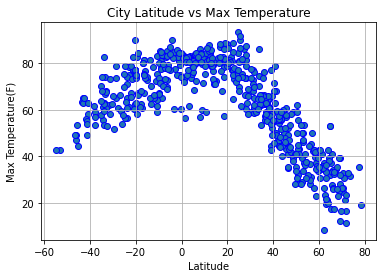

In [58]:
plt.scatter(clean_city_data['Lat'], clean_city_data['Max Temp'], marker="o", edgecolors = 'b')
plt.xlabel("Latitude")
plt.ylabel("Max Temperature(F)")
plt.title("City Latitude vs Max Temperature")
plt.grid(True)

# Save the figure
plt.savefig("City Latitude vs Max Temperature.png")

plt.show()

## Latitude vs. Humidity Plot

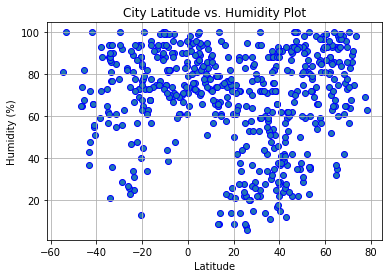

In [59]:
plt.scatter(clean_city_data['Lat'], clean_city_data['Humidity'], marker="o", edgecolors = 'b')
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title("City Latitude vs. Humidity Plot")
plt.grid(True)

# Save the figure
plt.savefig("City Latitude vs. Humidity Plot.png")

plt.show()

## Latitude vs. Cloudiness Plot

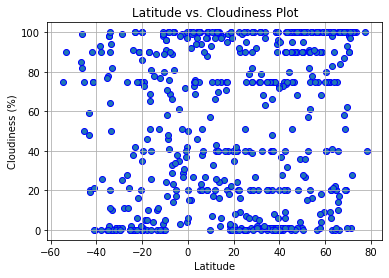

In [60]:
plt.scatter(clean_city_data['Lat'], clean_city_data['Cloudiness'], marker="o", edgecolors = 'b')
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title("Latitude vs. Cloudiness Plot")
plt.grid(True)

# Save the figure
plt.savefig("Latitude vs. Cloudiness Plot.png")

plt.show()

## Latitude vs. Wind Speed Plot

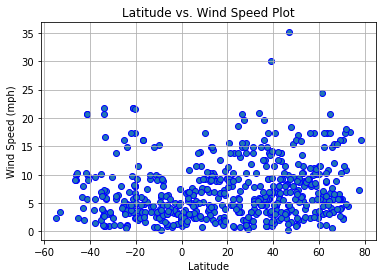

In [61]:
plt.scatter(clean_city_data['Lat'], clean_city_data['Wind Speed'], marker="o", edgecolors = 'b')
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("Latitude vs. Wind Speed Plot")
plt.grid(True)

# Save the figure
plt.savefig("Latitude vs. Wind Speed Plot.png")

plt.show()

## Linear Regression

In [62]:
Northern = clean_city_data.loc[(clean_city_data["Lat"] > 0)]
# len(Northern)
Southern = clean_city_data.loc[(clean_city_data["Lat"] < 0)]


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: -0.8932283273680977


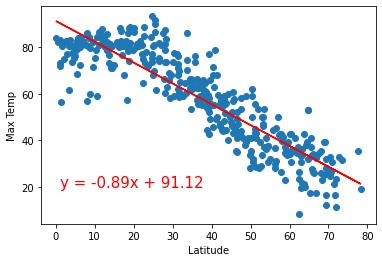

In [63]:
slope, intercept, r_value, p_value, std_err = st.linregress(Northern['Lat'], Northern['Max Temp'])
fit = slope * Northern['Lat'] + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

correlation = st.pearsonr(Northern['Lat'], Northern['Max Temp'])
plt.scatter(Northern['Lat'], Northern['Max Temp'])

plt.annotate(line_eq,(1,20),fontsize=15,color="red")
plt.plot(Northern['Lat'], fit,"-", color = "r")
# plt.xticks(Northern['Lat'], rotation=90)
plt.xlabel('Latitude')
plt.ylabel('Max Temp')
print(f"The r-value is: {r_value}")
# Save the figure
plt.savefig("Max Temp vs. Latitude Linear Regression.png")
plt.show()


####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.6947330977262254


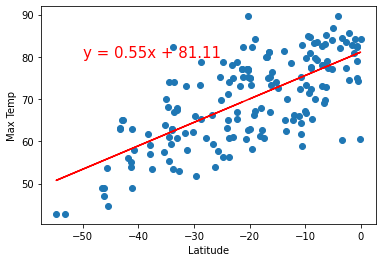

In [64]:
slope, intercept, r_value, p_value, std_err = st.linregress(Southern['Lat'], Southern['Max Temp'])
fit = slope * Southern['Lat'] + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

correlation = st.pearsonr(Southern['Lat'], Southern['Max Temp'])
plt.scatter(Southern['Lat'], Southern['Max Temp'])

plt.annotate(line_eq,(-50,80),fontsize=15,color="red")
plt.plot(Southern['Lat'], fit,"-", color = "r")
# plt.xticks(Southern['Lat'], rotation=90)
plt.xlabel('Latitude')
plt.ylabel('Max Temp')
print(f"The r-value is: {r_value}")
# Save the figure
plt.savefig("Max Temp vs. Latitude Linear Regression.png")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.10409779484703834


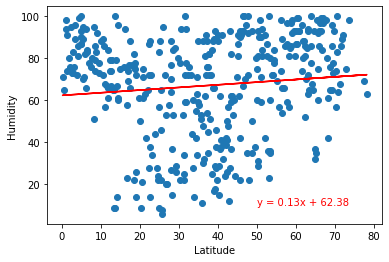

In [65]:
slope, intercept, r_value, p_value, std_err = st.linregress(Northern['Lat'], Northern['Humidity'])
fit = slope * Northern['Lat'] + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

correlation = st.pearsonr(Northern['Lat'], Northern['Humidity'])
plt.scatter(Northern['Lat'], Northern['Humidity'])

plt.annotate(line_eq,(50,10),fontsize=10,color="red")
plt.plot(Northern['Lat'], fit,"-", color = "r")
# plt.xticks(Northern['Lat'], rotation=90)
plt.xlabel('Latitude')
plt.ylabel('Humidity')
print(f"The r-value is: {r_value}")
# Save the figure
plt.savefig("Humidity vs. Latitude Linear Regression.png")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.19059175109854073


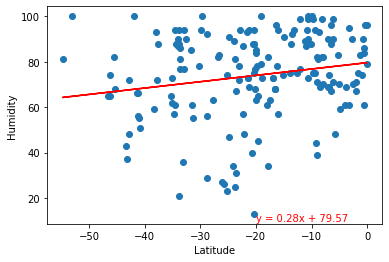

In [66]:
slope, intercept, r_value, p_value, std_err = st.linregress(Southern['Lat'], Southern['Humidity'])
fit = slope * Southern['Lat'] + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

correlation = st.pearsonr(Southern['Lat'], Southern['Humidity'])
plt.scatter(Southern['Lat'], Southern['Humidity'])

plt.annotate(line_eq,(-20,10),fontsize=10,color="red")
plt.plot(Southern['Lat'], fit,"-", color = "r")
# plt.xticks(Southern['Lat'], rotation=90)
plt.xlabel('Latitude')
plt.ylabel('Humidity')
print(f"The r-value is: {r_value}")
# Save the figure
plt.savefig("Humidity vs. Latitude Linear Regression.png")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.07037359204527857


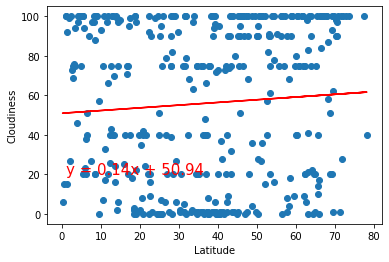

In [67]:
slope, intercept, r_value, p_value, std_err = st.linregress(Northern['Lat'], Northern['Cloudiness'])
fit = slope * Northern['Lat'] + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

correlation = st.pearsonr(Northern['Lat'], Northern['Cloudiness'])
plt.scatter(Northern['Lat'], Northern['Cloudiness'])

plt.annotate(line_eq,(1,20),fontsize=15,color="red")
plt.plot(Northern['Lat'], fit,"-", color = "r")
# plt.xticks(Northern['Lat'], rotation=90)
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
print(f"The r-value is: {r_value}")
# Save the figure
plt.savefig("Cloudiness vs. Latitude Linear Regression.png")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.05675234504444731


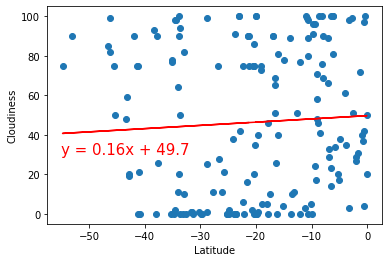

In [68]:
slope, intercept, r_value, p_value, std_err = st.linregress(Southern['Lat'], Southern['Cloudiness'])
fit = slope * Southern['Lat'] + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

correlation = st.pearsonr(Southern['Lat'], Southern['Cloudiness'])
plt.scatter(Southern['Lat'], Southern['Cloudiness'])

plt.annotate(line_eq,(-55,30),fontsize=15,color="red")
plt.plot(Southern['Lat'], fit,"-", color = "r")
# plt.xticks(Southern['Lat'], rotation=90)
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
print(f"The r-value is: {r_value}")
# Save the figure
plt.savefig("Cloudiness vs. Latitude Linear Regression.png")
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.14899466415781576


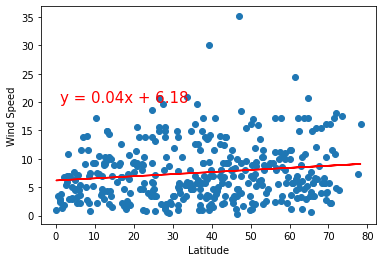

In [69]:
slope, intercept, r_value, p_value, std_err = st.linregress(Northern['Lat'], Northern['Wind Speed'])
fit = slope * Northern['Lat'] + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

correlation = st.pearsonr(Northern['Lat'], Northern['Wind Speed'])
plt.scatter(Northern['Lat'], Northern['Wind Speed'])

plt.annotate(line_eq,(1,20),fontsize=15,color="red")
plt.plot(Northern['Lat'], fit,"-", color = "r")
# plt.xticks(Northern['Lat'], rotation=90)
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
print(f"The r-value is: {r_value}")
# Save the figure
plt.savefig("Wind Speed (mph) vs. Latitude Linear Regression.png")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: -0.22506452651851452


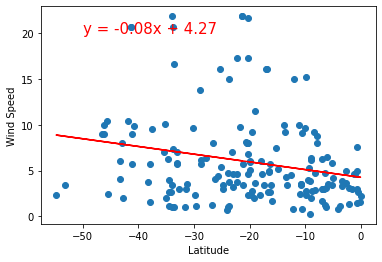

In [70]:
slope, intercept, r_value, p_value, std_err = st.linregress(Southern['Lat'], Southern['Wind Speed'])
fit = slope * Southern['Lat'] + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

correlation = st.pearsonr(Southern['Lat'], Southern['Wind Speed'])
plt.scatter(Southern['Lat'], Southern['Wind Speed'])

plt.annotate(line_eq,(-50,20),fontsize=15,color="red")
plt.plot(Southern['Lat'], fit,"-", color = "r")
# plt.xticks(Southern['Lat'], rotation=90)
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
print(f"The r-value is: {r_value}")
# Save the figure
plt.savefig("Wind Speed (mph) vs. Latitude Linear Regression.png")
plt.show()